# HW10 Baoling Zhou

# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.


The data was organized  by Dr. Sina Kashuk at CUSP.
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


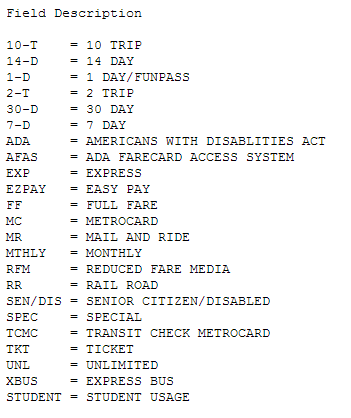

In [1]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

In [2]:
import numpy as np
import pylab as pl
import pandas as pd
import datetime as dt
from sklearn.cluster import KMeans

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

The data are available to you as a *python data cube*. you can load it as 

```
np.load(“MTA_Fare.npy")
```

and you will end up with a python numpy array of 
shape (600, 23, 194)




In [19]:
mtaRides = np.load("MTA_Fare.npy")

In [20]:
mtaRides = mtaRide.astype(float)
mtaRides[mtaRides==-1] = np.nan

## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [21]:
#600 stations, 23 card types, 194 weeks of records
mtaRides.shape

(600, 23, 194)

In [23]:
#as described in the instruction for some of the analysis 
#one can sum time series for all stations
print (mtaRides.shape)
mta_allsum = np.nansum(mtaRides, axis=0)
print (mta_allsum.shape)
#or for all ride types
#mta_allsum = np.nansum(mtaRides, axis=1)
#print (mta_allsum.shape)

(600, 23, 194)
(23, 194)


In [25]:
weekly_swipe = pd.DataFrame(np.nansum(mta_allsum,axis=0))

In [26]:
weekly_swipe.head()

,0
0,26720267.0
1,29265971.0
2,29601189.0
3,29387592.0
4,29185768.0


In [27]:
weekly_swipe.columns=['n_swipe']

In [28]:
weekly_swipe['week']= "5/21/2010"

In [29]:
weekly_swipe['week'] = weekly_swipe['week'].apply(lambda x: pd.to_datetime(x))

In [30]:
weekly_swipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 2 columns):
n_swipe    194 non-null float64
week       194 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.1 KB


In [32]:
for i in range(1,len(weekly_swipe)):
    weekly_swipe.week.iloc[i] = weekly_swipe.week.iloc[i-1] + datetime.timedelta(days=7)

/Users/zhoubaoling/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [33]:
weekly_swipe.head(15)

,n_swipe,week
0,26720267.0,2010-05-21
1,29265971.0,2010-05-28
2,29601189.0,2010-06-04
3,29387592.0,2010-06-11
4,29185768.0,2010-06-18
5,26211666.0,2010-06-25
6,28683614.0,2010-07-02
7,29125646.0,2010-07-09
8,28803814.0,2010-07-16
9,28599546.0,2010-07-23


In [35]:
print ("mean swipes by week {:.2f}".format(weekly_swipe.n_swipe.mean()))
print ("stdev swipes by week {:.2f}".format(weekly_swipe.n_swipe.std()))
thresholds = [weekly_swipe.n_swipe.mean() + 3 * weekly_swipe.n_swipe.std(), 
              weekly_swipe.n_swipe.mean() - 3 * weekly_swipe.n_swipe.std()]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))

mean swipes by week 29781349.87
stdev swipes by week 2991680.90
3-sigma thresholds 38756392.58 20806307.17


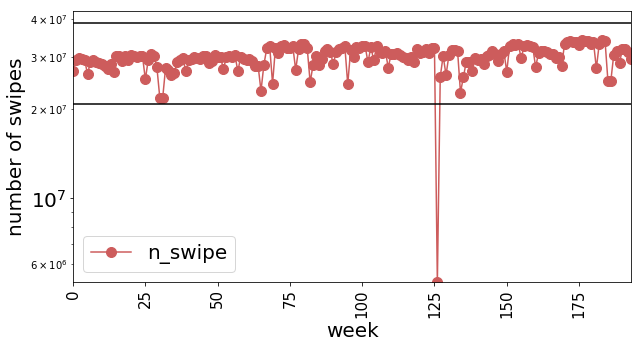

In [40]:
ax = weekly_swipe.plot(logy=True, figsize=(10,5), style=".-", ms=20, color="IndianRed")
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[0], thresholds[0]], color='k')
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]], color='k')
pl.xticks(rotation=90, fontsize=15)
pl.yticks(fontsize=20)
pl.ylim(-20, pl.ylim()[1])
pl.legend(fontsize=20)
pl.ylabel("number of swipes", fontsize=20)
pl.xlabel("week", fontsize=20);

#### Figure 1: Plot of total MTA swipes during the given 194 weeks. There is prominent event occurred around the week 126.

In [42]:
weekly_swipe[(weekly_swipe.n_swipe < thresholds[1])]

,n_swipe,week
126,5218686.0,2012-10-19


#### The most prominent event happend on the week 126 from Oct 19th to 26th in 2012. On that week, the number of MTA card swipes was lower than 3 sigma below the average number of swipes. It is probably caused by the Hurricane Sandy which occured on Oct 26th 2012. 

## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [48]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [51]:
rider_type = pd.DataFrame(mta_allsum).T

In [54]:
rider_type.columns = ridetype

In [55]:
rider_type.head()

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
0,11494615.0,530524.0,47801.0,186551.0,46808.0,3697443.0,8551937.0,10063.0,333197.0,512032.0,...,123134.0,790110.0,59809.0,28221.0,0.0,124693.0,21060.0,6128.0,358.0,0.0
1,12526859.0,583533.0,51486.0,199229.0,64353.0,3981808.0,9486394.0,11847.0,282755.0,578023.0,...,151948.0,908068.0,69209.0,32333.0,0.0,121713.0,21670.0,6120.0,474.0,0.0
2,12766627.0,586194.0,51636.0,199668.0,56994.0,4033030.0,9476538.0,12277.0,302028.0,615537.0,...,151538.0,914124.0,69574.0,32618.0,0.0,122181.0,21433.0,6490.0,465.0,0.0
3,12653675.0,562602.0,52063.0,196389.0,37429.0,4032753.0,9450081.0,11221.0,305513.0,606270.0,...,147094.0,902549.0,68099.0,32404.0,0.0,122051.0,21630.0,6590.0,484.0,0.0
4,12809694.0,548858.0,51153.0,194883.0,35210.0,3925446.0,9294002.0,10515.0,335780.0,563446.0,...,137888.0,855573.0,66377.0,31933.0,176.0,119776.0,20297.0,6313.0,452.0,0.0


/Users/zhoubaoling/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  
/Users/zhoubaoling/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  # This is added back by InteractiveShellApp.init_path()


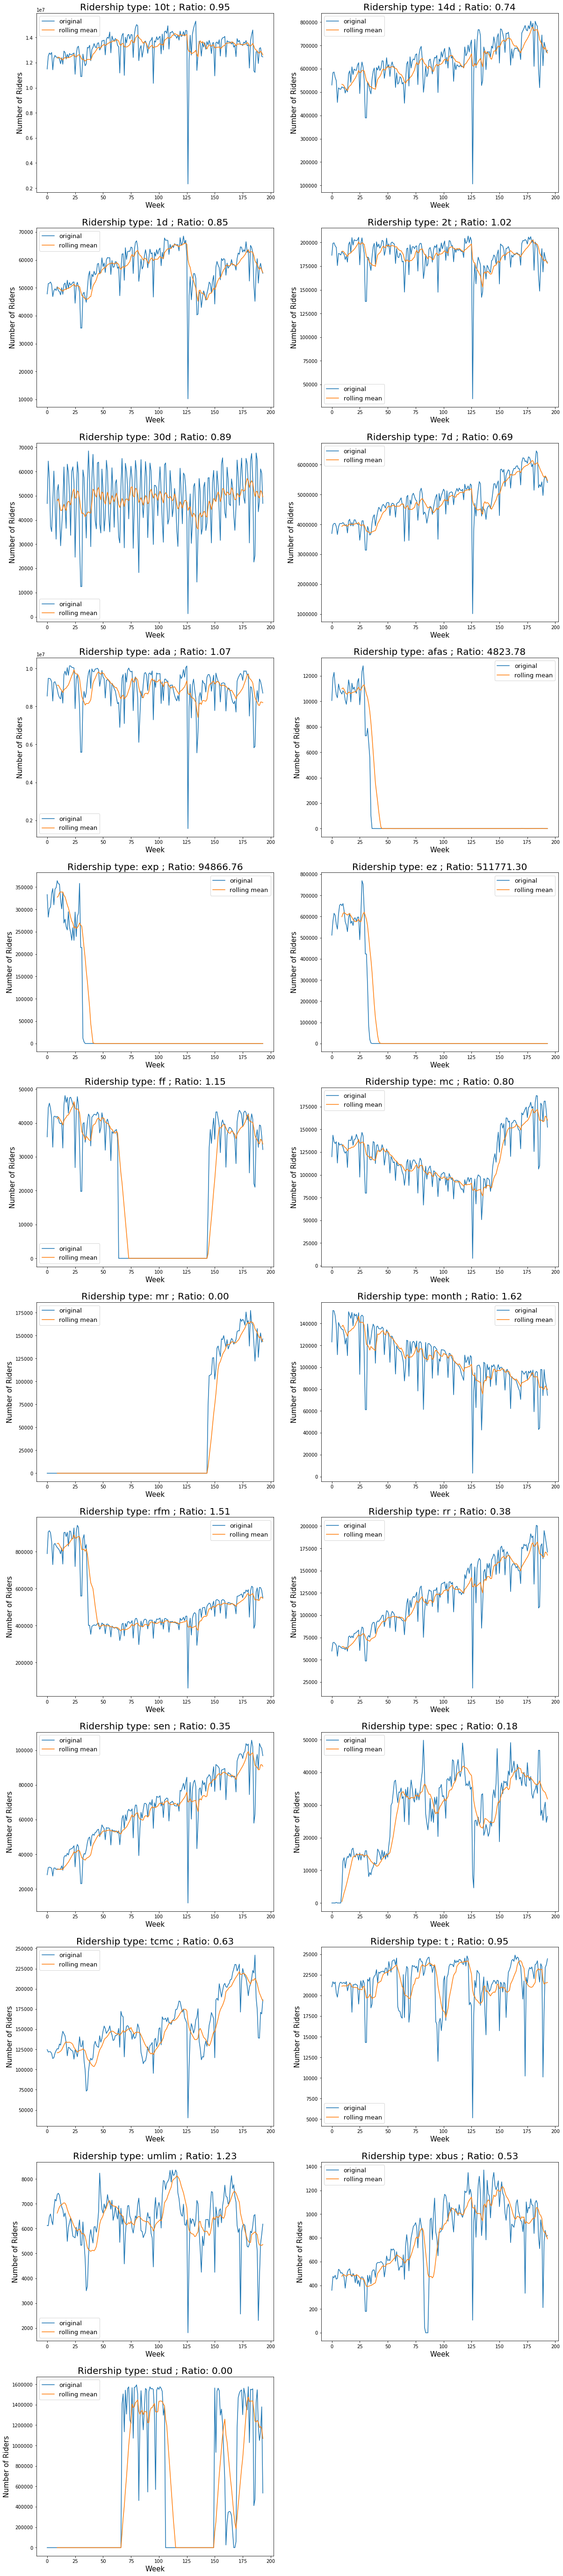

In [66]:
fig = pl.figure(figsize=(20,100))
ratio = []
for i, key in enumerate(ridetype):
    #rolling mean, window 10
    ax = fig.add_subplot(12,2,i+1)
    rolling_mean = pd.rolling_mean(rider_type[key], 10)

    ax.plot(np.arange(len(rider_type[key])), rider_type[key], label="original")
    ax.plot(np.arange(len(rider_type[key])), rolling_mean, label="rolling mean")
    
    ratio.append(pd.rolling_mean(rider_type[key], 10).dropna().head(10).sum() / pd.rolling_mean(rider_type[key], 10).dropna().tail(10).sum())
    ax.set_title("Ridership type: %s ; Ratio: %.2f"%(key,ratio[i]), fontsize=20)
    pl.ylabel("Number of Riders", fontsize=15)
    pl.xlabel("Week", fontsize=15)
    pl.legend(fontsize=13)


#### Figure 2. Plot the original swipes and the rolling mean of 23 unique riderships during the given 194 weeks. Card type: 14d, 7d, rr and sen shows steady growing trend in their popularity. On the other hand, card type: month, shows a steady declining trend.

In [59]:
rider_type.columns

Index(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp', 'ez', 'ff',
       'mc', 'mr', 'month', 'rfm', 'rr', 'sen', 'spec', 'tcmc', 't', 'umlim',
       'xbus', 'stud'],
      dtype='object')

## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [67]:
mta_station = np.nansum(mtaRides, axis=1)
print (mta_station.shape)

(600, 194)


In [68]:
station = pd.DataFrame(mta_station).T

In [69]:
station.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,126878.0,37306.0,6606.0,16378.0,18564.0,19987.0,12449.0,11091.0,10482.0,147187.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,149477.0,46464.0,6881.0,17408.0,19903.0,20625.0,13644.0,11659.0,11030.0,154826.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,152383.0,49359.0,7229.0,17595.0,19948.0,21225.0,13719.0,12037.0,10881.0,155958.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,160175.0,44849.0,5731.0,14242.0,16076.0,17412.0,11460.0,9809.0,9123.0,154914.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,162641.0,41509.0,7032.0,17589.0,20283.0,20909.0,14094.0,11944.0,10923.0,157628.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
total_in_station = pd.DataFrame(total_card).T

In [72]:
N = len(station)

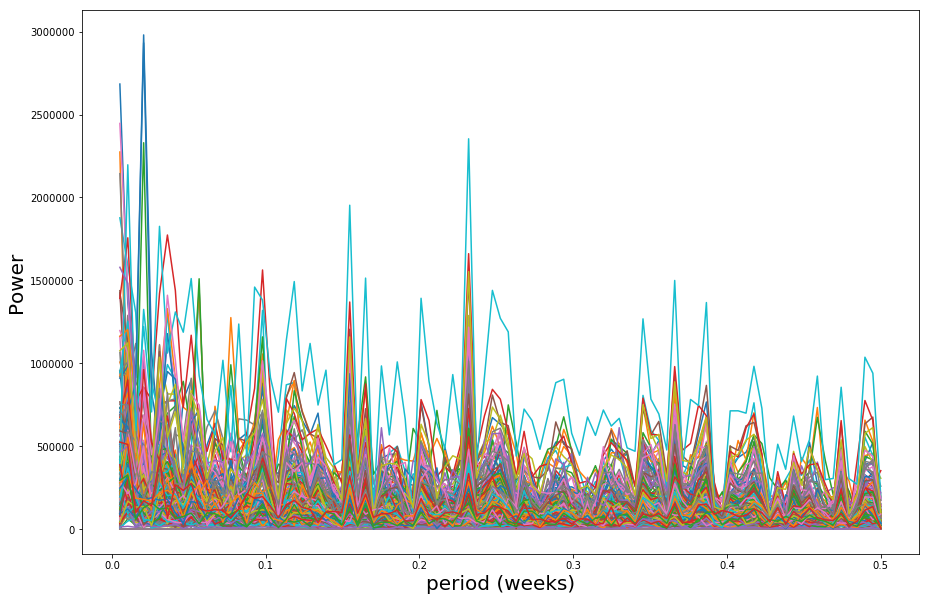

In [96]:
fig=pl.figure(figsize=(15,10))
ax=fig.add_subplot(111)
for i in range(len(station)):
    f = np.abs(np.fft.rfft(station[i]))
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
pl.xlabel("period (weeks)", fontsize=20)
pl.ylabel("Power", fontsize=20)
#ax.set_xticklabels([ "%.2f"%(1/f) for f in ax.get_xticks()], fontsize=20)

#### Figure 3: Plot the frequency of swipes in 600 different stations.

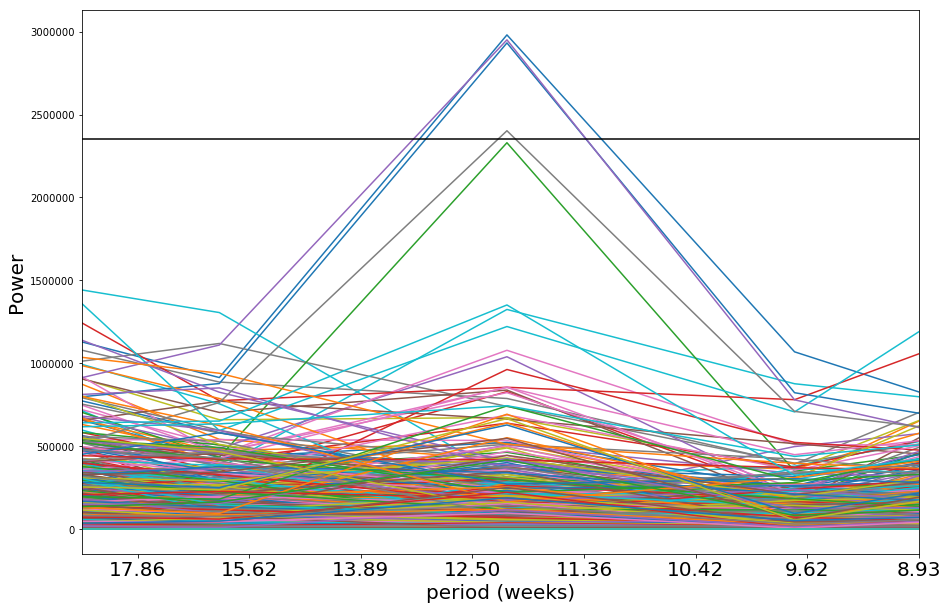

In [144]:
fig=pl.figure(figsize=(15,10))
ax=fig.add_subplot(111)
peak = []
for i in station.columns:
    f = np.abs(np.fft.rfft(station[i]))
    #ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'o', ms=20)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
    if f[4] > 2.35e6:
        peak.append(i)
        #print(f.shape)
ax.plot((0.013, 0.028), (2.35e6, 2.35e6), 'k-')
ax.set_xlim(0.013, 0.028)
ax.set_xticklabels([ "%.2f"%(1/4./f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("period (weeks)", fontsize=20)
pl.ylabel("Power", fontsize=20)

In [145]:
peak

[0, 150, 194, 327]

#### Figure 4: Zoom in the figure 3 and show the stations who has the most prominent periodic trend on an annual period. The threshold 2.36e6 can be used to identiy the 4 stations with the highest frequency.

In [130]:
week = pd.date_range(start='05/28/2010', end='02/07/2014', freq='W-Fri')
week

DatetimeIndex(['2010-05-28', '2010-06-04', '2010-06-11', '2010-06-18',
               '2010-06-25', '2010-07-02', '2010-07-09', '2010-07-16',
               '2010-07-23', '2010-07-30',
               ...
               '2013-12-06', '2013-12-13', '2013-12-20', '2013-12-27',
               '2014-01-03', '2014-01-10', '2014-01-17', '2014-01-24',
               '2014-01-31', '2014-02-07'],
              dtype='datetime64[ns]', length=194, freq='W-FRI')

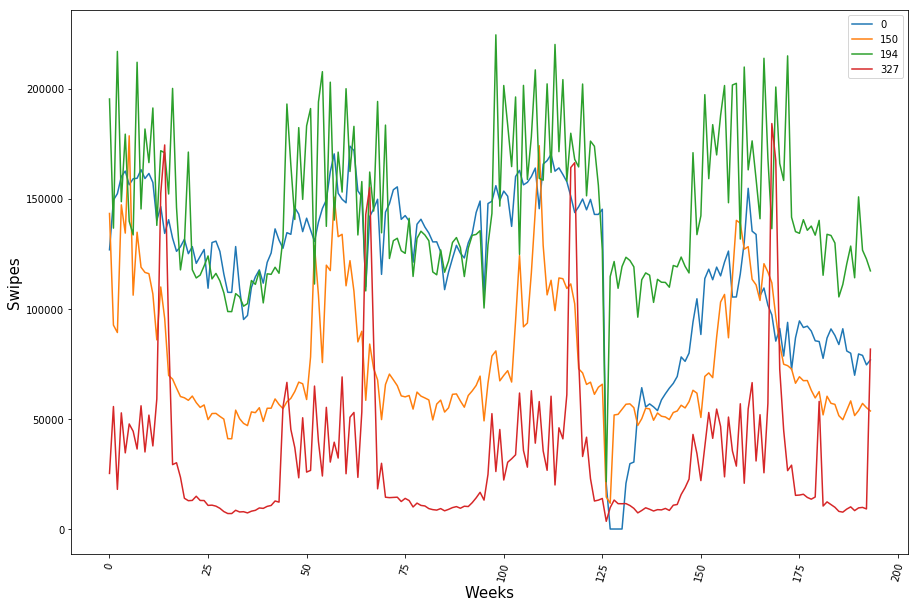

In [137]:
fig=pl.figure(figsize=(15,10))
ax=fig.add_subplot(111)
for i in peak:
    pl.plot(station[i],label=i)
pl.xticks(rotation=75)
pl.xlabel('Weeks',fontsize = 15)
pl.ylabel('Swipes',fontsize = 15)
pl.legend()

#### Figure 5: Plot the top 4 stations which have annual periodic trend, which are station:  0, 150,194,327.

## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

removing empty light curves

```
tots = tots[tots.std(1)>0]
```

with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

then you can run:

```
km.fit(vals)
```

In [148]:
data = mtaRides

In [150]:
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T

In [151]:
tots = tots[tots.std(1)>0]

/Users/zhoubaoling/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [152]:
km = KMeans(n_clusters=10)


In [153]:
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

In [154]:
km.fit(vals)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

0.865012581133


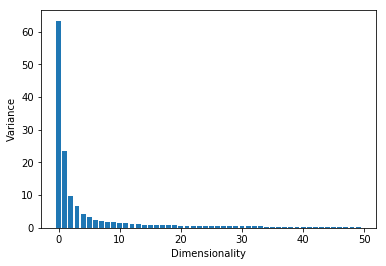

In [162]:
from sklearn.decomposition import PCA
n=50
pca = PCA(n)
Xproj = pca.fit_transform(vals)
eigenvalues = pca.explained_variance_
print(pca.explained_variance_ratio_.sum())
plt.bar(np.arange(n), eigenvalues);
plt.xlabel("Dimensionality")
plt.ylabel("Variance")
plt.show()

#### Figure 6. Reduce the number of demension of mta swipes data into 50.

In [160]:
cluster_labels = km.fit_predict(vals)

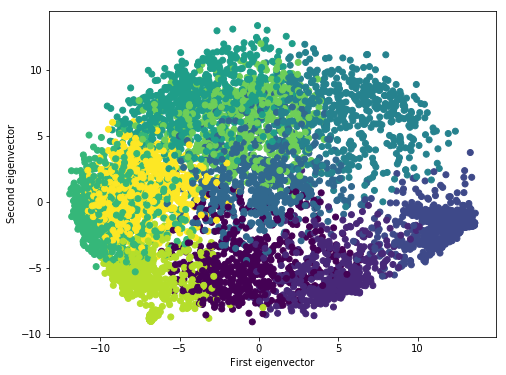

In [163]:
plt.figure(2, figsize=(8, 6))
plt.clf()
# Plot the training points
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=cluster_labels)
plt.xlabel('First eigenvector')
plt.ylabel('Second eigenvector')
plt.show()

#### Figure 7. Cluster the time series, i.e. identify groups of time series that look similar among each other

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. Look at the notebook on fourier transforms in https://github.com/fedhere/UInotebooks/tree/master/timeseries. If you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft()  

```
np.fft.rfft(mydata) 
```  

      will return the *real* part of the fourier transform (the fourier transform is a *complex* object, and therefore it has a real and an *imaginary* component - that is just math; all you need to know is that you need the real part). But what you want is its absolute value: np.abs(). 
      To plot the fourier transform you may want the x-axis to be in frequency. To get the x-axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

```
np.fft.rfftfreq(N, d) 
```     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the *sample spacing*, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1!)


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

*  after you operate on the array to collapse an axis, always check the dimensionality to assure you have indeed collapsed the right axis! see cell below

```
import numpy as np
data = np.random.rand(100,10)

print(data.shape)
Out[12]: (100, 10)

print(data.mean())
Out[13]:  0.4902457782

print(data.mean(axis=0).shape, data.mean(axis=1).shape)
Out[14]: (10,) (100,)

```

In [2]:
#after reading the datacube you should see:
mtaRides.shape


(600, 23, 194)

ride types list

In [6]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [9]:
#after that I create a date range (for example with pd.date_range())
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)

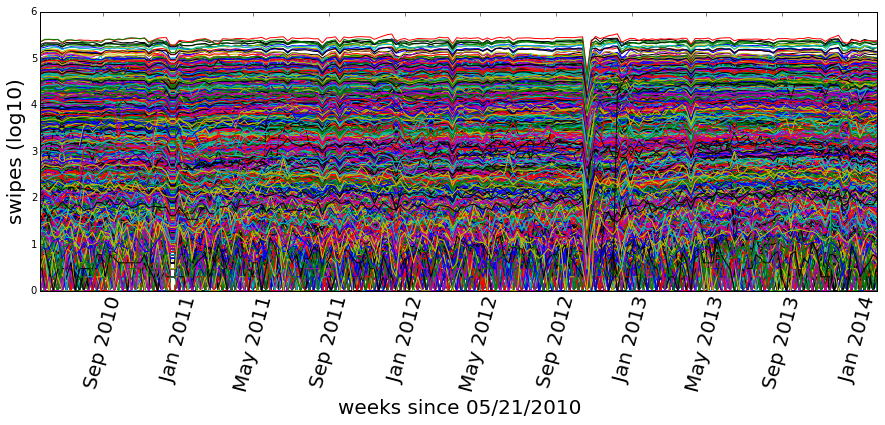

In [6]:
#as described in the instruction for some of the analysis 
#one can sum time series for all stations
print (mtaRide.shape)
mta_allsum = np.nansum(mtaRides, axis=0)
print (mta_allsum.shape)
#or for all ride types
mta_allsum = np.nansum(mtaRides, axis=1)
print (mta_allsum.shape)



(600, 23, 194)
(23, 194)
(600, 194)


## NOTE ON THE TREND DETECTION:
### you should find the *card type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

std: 153167.095823 
flux ratio beginning to end 1.53960256599
std: 33307.6081244 
flux ratio beginning to end 0.378670623705


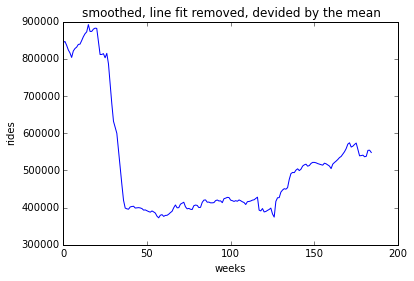

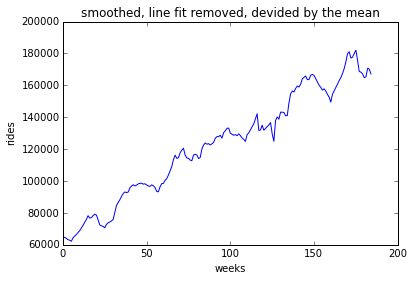

to determine if there is a trend or strucutre you can inspect the time series visually, since there are only 23!
an alternative, algorithmic way to do it, is to fit a line to the (smoothed) time series  and look at the residuals.

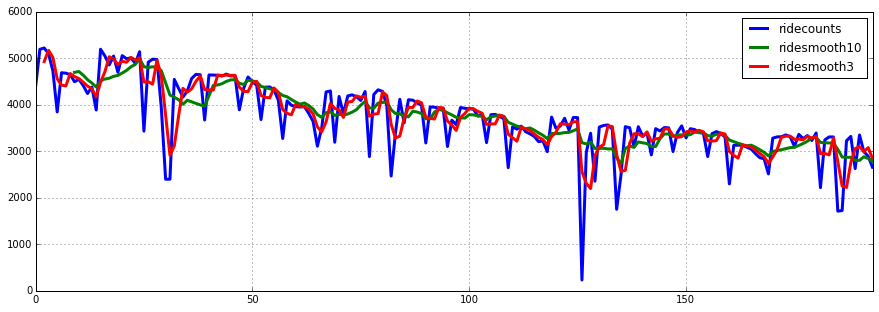

In [14]:
#here is an example of an individual time series that shows a trend, 
#after smoothing by 3 and 10 weeks

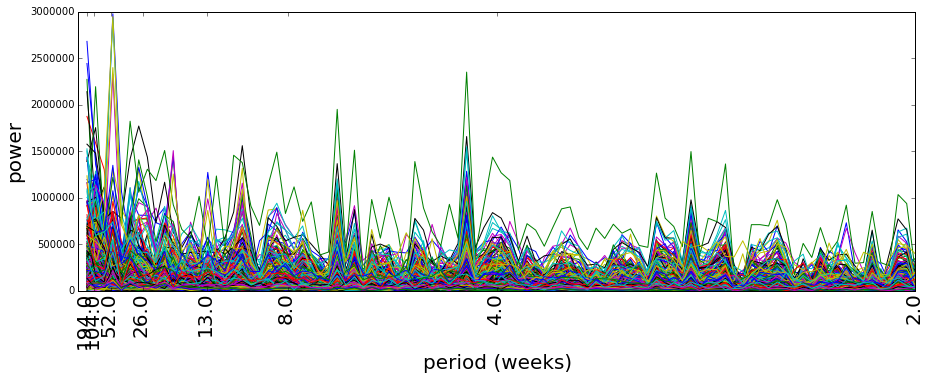

In [51]:
# this is a "power spectrum": the plot of the absolute value of the fourier transform. 
# I changed the xtick labels from frequecy (1/week) to period (in weeks)
# to facilitate the visual identification of the 1-year period peak
# (notice however that np.fft.rfftfreq(N, d)  returns frequency, the inverse of the period: frequency = 1/period. 
# All I did was changing the tick labels): 

...
ax.set_xticklabels([ "%s"%(1/f) for f in allperiods], rotation=90)

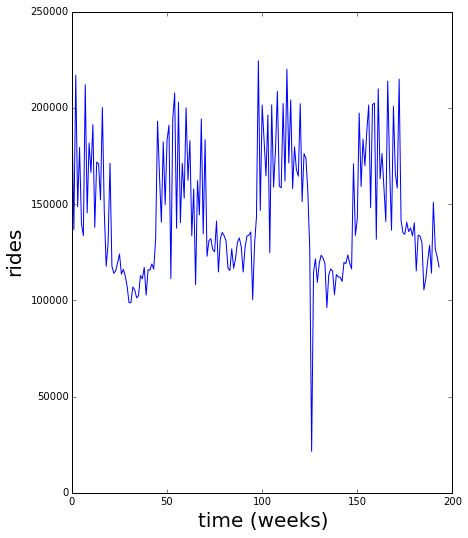

In [63]:
#and here is one of he periodic time series you should find by identifying the time series with the most power 
#at 1/52 weeks frequency in fourier space

## ASH Score 100. Extra CRedit 100